In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns

import random

random.seed(42)
pd.set_option('display.max_columns', None)

def count_decimal_places(num, *, remove_single_zero=False):
    str_num = str(num)
    if remove_single_zero and str_num.endswith('.0'):
        return 0
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

pd.set_option('display.float_format', lambda x: '{:.{}f}'.format(x, min(count_decimal_places(x), 6)))

In [2]:
def load_dataset(path, mode, scenario):
    if path.endswith('.v1.txt'):
        data = pd.read_csv(path, sep=' ', header=None, names=['Latency', 'Sequence'], skiprows=lambda n: not n % 2)
    elif path.endswith('.v2.txt'):
        data = pd.read_csv(path, sep=' ', header=None, names=['Latency', 'Sequence'])
    elif path.endswith('.v3.txt'):
        data = pd.read_csv(path, sep=',', header=None, names=['Sequence', 'Latency'])

    data['Mode'] = mode
    data['Scenario'] = scenario
    return data

WORKLOADS_BASE = '../workloads'

df = pd.concat(
    [ load_dataset(f'{WORKLOADS_BASE}/{workload}/samples/{file}', mode, scenario) for (workload, file, mode, scenario) in [
        ['ping-echo', 'logs-nothing-baseline-6.v3.txt', 'No Service Mesh', 'Baseline'],
        ['ping-echo', 'logs-nothing-optimization-6.v3.txt', 'No Service Mesh', 'Optimization'],
        #['ping-echo', 'logs-sidecar-baseline-8.v3.txt', 'Sidecar', 'Baseline'],
        #['ping-echo', 'logs-sidecar-optimization-8.v3.txt', 'Sidecar', 'Optimization'],
        ['ping-echo', 'logs-ztunnel-baseline-7.v3.txt', 'Ambient Mesh', 'Baseline'],
        ['ping-echo', 'logs-ztunnel-optimization-7.v3.txt', 'Ambient Mesh', 'Optimization'],
    ] ],
    ignore_index=True,
)

In [3]:
#df = df[df.Sequence < 2000].copy()

In [4]:
df

,Sequence,Latency,Mode,Scenario
0,0,677806,No Service Mesh,Baseline
1,1,420651,No Service Mesh,Baseline
2,2,451801,No Service Mesh,Baseline
3,3,447191,No Service Mesh,Baseline
4,4,434968,No Service Mesh,Baseline
...,...,...,...,...
8758,2070,410389,Ambient Mesh,Optimization
8759,2071,618586,Ambient Mesh,Optimization
8760,2072,507120,Ambient Mesh,Optimization
8761,2073,239557,Ambient Mesh,Optimization


In [5]:
df.groupby(['Mode', 'Scenario'])[['Mode', 'Scenario']].count()

Mode  Scenario
Mode            Scenario                    
Ambient Mesh    Baseline      2129      2129
                Optimization  2075      2075
No Service Mesh Baseline      2413      2413
                Optimization  2146      2146

In [6]:
df['Latency_diff'] = df.groupby(['Mode', 'Scenario']).Latency.diff().abs().fillna(0)

In [7]:
df

,Sequence,Latency,Mode,Scenario,Latency_diff
0,0,677806,No Service Mesh,Baseline,0.0
1,1,420651,No Service Mesh,Baseline,257155.0
2,2,451801,No Service Mesh,Baseline,31150.0
3,3,447191,No Service Mesh,Baseline,4610.0
4,4,434968,No Service Mesh,Baseline,12223.0
...,...,...,...,...,...
8758,2070,410389,Ambient Mesh,Optimization,304649.0
8759,2071,618586,Ambient Mesh,Optimization,208197.0
8760,2072,507120,Ambient Mesh,Optimization,111466.0
8761,2073,239557,Ambient Mesh,Optimization,267563.0


In [8]:
df.groupby(['Mode', 'Scenario'])[['Latency', 'Latency_diff']].describe()

Latency                                       
                               count          mean          std      min   
Mode            Scenario                                                   
Ambient Mesh    Baseline      2129.0 505595.982151 96317.241088 213087.0  \
                Optimization  2075.0 398893.452530 86057.751079 185011.0   
No Service Mesh Baseline      2413.0 501216.593452 91021.625207 218671.0   
                Optimization  2146.0 420765.936626 83453.568444 171180.0   

                                                                     
                                  25%      50%       75%       max   
Mode            Scenario                                             
Ambient Mesh    Baseline     443634.0 487284.0  540504.0 1191078.0  \
                Optimization 351582.0 382382.0  425230.5 1001248.0   
No Service Mesh Baseline     444961.0 483164.0  533101.0  955782.0   
                Optimization 368624.0 399210.5 454388.75  886560.0   

                             Latency_diff                                 
                                    count         mean          std min   
Mode            Scenario                                                  
Ambient Mesh    Baseline           2129.0 96662.794270 85360.451565 0.0  \
                Optimization       2075.0 81299.676627 83228.923808 0.0   
No Service Mesh Baseline           2413.0 90407.109822 83097.661957 0.0   
                Optimization       2146.0 82942.402144 74166.977127 0.0   

                                                                  
                                  25%     50%       75%      max  
Mode            Scenario                                          
Ambient Mesh    Baseline      31847.0 72914.0  143035.0 648409.0  
                Optimization  24095.0 54546.0  114784.5 679767.0  
No Service Mesh Baseline      27449.0 63905.0  129416.0 470384.0  
                Optimization 24322.25 60727.0 126902.25 525977.0

In [9]:
df.Latency.quantile(.99)

745289.7999999998

In [10]:
df.Latency.max()

1191078

In [11]:
latency_p99 = df[df.Latency <= df.Latency.quantile(.99)]

In [12]:
latency_p99.groupby(['Mode', 'Scenario']).Latency.agg(
    p25=lambda column: column.quantile(.25),
    p50=lambda column: column.quantile(.50),
    p75=lambda column: column.quantile(.75),
)

p25      p50       p75
Mode            Scenario                                
Ambient Mesh    Baseline     442691.0 485818.0  537116.5
                Optimization 351513.0 382103.0  423659.0
No Service Mesh Baseline     443983.0 481832.0  529713.5
                Optimization 368605.5 399145.0 452569.75

In [13]:
jitter = latency_p99.groupby(['Mode', 'Scenario']).Latency.std(ddof=0)
jitter

Mode             Scenario    
Ambient Mesh     Baseline       88440.404120
                 Optimization   79792.937463
No Service Mesh  Baseline       83247.877712
                 Optimization   80861.114336
Name: Latency, dtype: float64

In [14]:
latency_diff_p99 = df[df.Latency_diff <= df.Latency_diff.quantile(.99)]

In [15]:
print('removed entries > p99 latency:')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count() - latency_p99.groupby(['Mode', 'Scenario'])[['Latency']].count())

print('total')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count())

removed entries > p99 latency:


Latency
Mode            Scenario             
Ambient Mesh    Baseline           30
                Optimization       10
No Service Mesh Baseline           42
                Optimization        6

total


Latency
Mode            Scenario             
Ambient Mesh    Baseline         2129
                Optimization     2075
No Service Mesh Baseline         2413
                Optimization     2146

In [16]:
df[df.Latency > df.Latency.quantile(.99)]

,Sequence,Latency,Mode,Scenario,Latency_diff
64,64,760287,No Service Mesh,Baseline,123409.0
67,67,774116,No Service Mesh,Baseline,313725.0
73,73,749183,No Service Mesh,Baseline,191294.0
94,94,848985,No Service Mesh,Baseline,321268.0
106,106,752395,No Service Mesh,Baseline,274614.0
...,...,...,...,...,...
7868,1180,887965,Ambient Mesh,Optimization,336985.0
8185,1497,991610,Ambient Mesh,Optimization,593094.0
8222,1534,871483,Ambient Mesh,Optimization,509145.0
8288,1600,788791,Ambient Mesh,Optimization,243538.0


In [17]:
print('removed entries > p99 latency diff:')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count() - latency_diff_p99.groupby(['Mode', 'Scenario'])[['Latency']].count())

print('total')
display(df.groupby(['Mode', 'Scenario'])[['Latency']].count())

removed entries > p99 latency diff:


Latency
Mode            Scenario             
Ambient Mesh    Baseline           21
                Optimization       32
No Service Mesh Baseline           21
                Optimization       14

total


Latency
Mode            Scenario             
Ambient Mesh    Baseline         2129
                Optimization     2075
No Service Mesh Baseline         2413
                Optimization     2146

In [18]:
df[df.Latency_diff > df.Latency_diff.quantile(.99)]

,Sequence,Latency,Mode,Scenario,Latency_diff
179,179,421559,No Service Mesh,Baseline,382797.0
229,229,248005,No Service Mesh,Baseline,439089.0
546,546,863311,No Service Mesh,Baseline,420795.0
547,547,400611,No Service Mesh,Baseline,462700.0
607,607,899979,No Service Mesh,Baseline,433437.0
...,...,...,...,...,...
8370,1682,743673,Ambient Mesh,Optimization,516339.0
8371,1683,266585,Ambient Mesh,Optimization,477088.0
8524,1836,332376,Ambient Mesh,Optimization,368275.0
8742,2054,240534,Ambient Mesh,Optimization,511589.0


In [19]:
def format_ns(ns, to):
    convert_table = {
        'ns': 1,
        'us': 1/1_000,
        'ms': 1/1_000_000,
    }
    number = ns * convert_table[to]
    return '{:.{}f}'.format(number, min(count_decimal_places(number, remove_single_zero=True), 6))

/tmp/ipykernel_1671487/3261602205.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


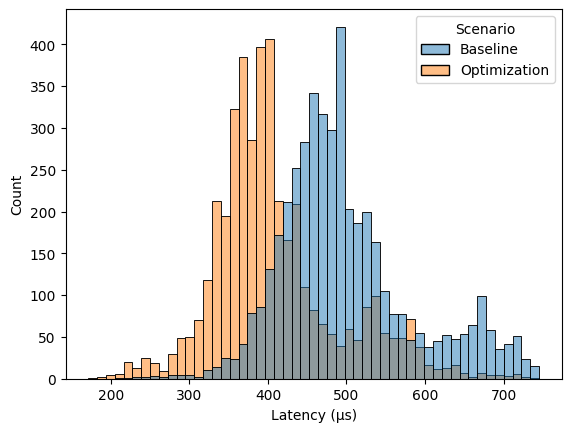

In [20]:
g = sns.histplot(data=latency_p99, x='Latency', hue='Scenario')

g.set(
    #title='Latency -- p99',
    xlabel='Latency (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

/tmp/ipykernel_1671487/1693546041.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


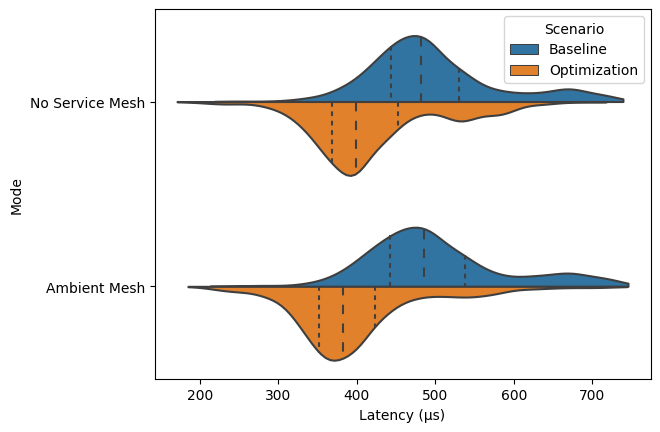

In [21]:
g = sns.violinplot(data=latency_p99, x='Latency', y='Mode', split=True, hue='Scenario', inner='quart', cut=0)

g.set(
    #title='Latency -- p99',
    xlabel='Latency (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

g.figure.savefig('ping-echo-violinplot-latency.svg', bbox_inches='tight')

/tmp/ipykernel_1671487/693985074.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


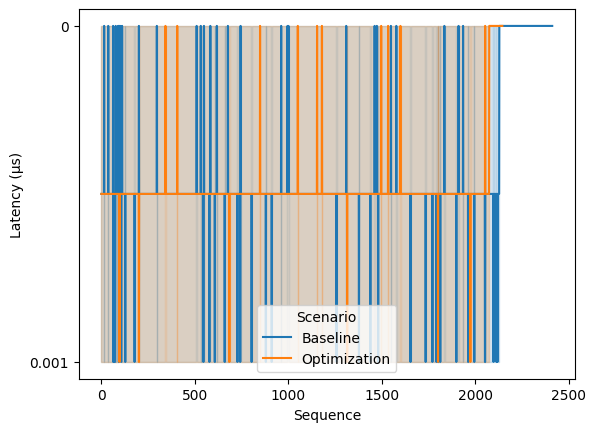

In [25]:
g = sns.lineplot(data=latency_p99, x='Sequence', y='Mode', hue='Scenario')

g.set(
    #title='Latency -- p99',
    ylabel='Latency (µs)',
    #xlabel='Sequence',
    yticklabels=[format_ns(tick, 'us') for tick in g.get_yticks()],
);

g.figure.savefig('ping-echo-lineplot-latency.svg', bbox_inches='tight')

/tmp/ipykernel_1671487/619990491.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


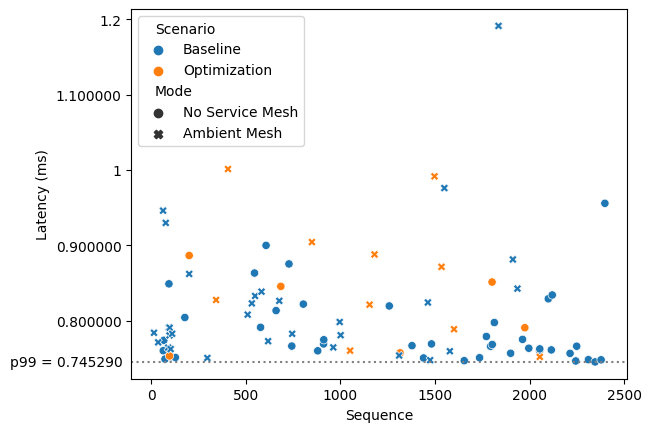

In [26]:
latency_outliers = df[df.Latency > df.Latency.quantile(.99)]
g = sns.scatterplot(data=latency_outliers, x='Sequence', y='Latency', hue='Scenario', style='Mode')

g.axhline(y=df.Latency.quantile(.99), linewidth=1.5, color='gray', ls=':')
g.text(-150, df.Latency.quantile(.99), f"p99 = {format_ns(df.Latency.quantile(.99), 'ms')}", va='center', ha='right')

g.set(
    #title='Latency -- >p99',
    ylabel='Latency (ms)',
    #xlabel='Sequence',
    yticklabels=[format_ns(tick, 'ms') for tick in g.get_yticks()],
);

g.figure.savefig('ping-echo-lineplot-latency-spikes.svg', bbox_inches='tight')

/tmp/ipykernel_1671487/1260539480.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


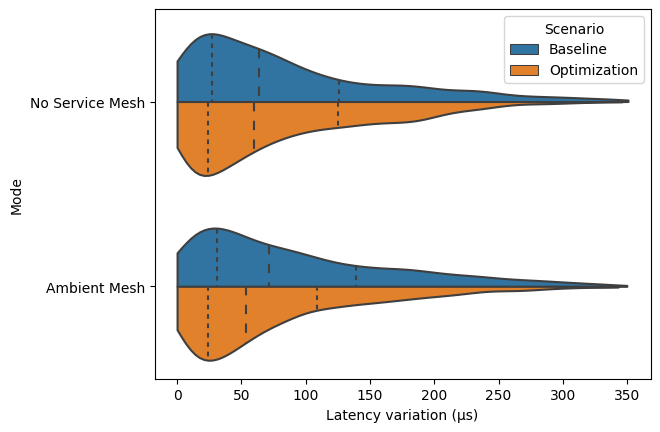

In [22]:
g = sns.violinplot(data=latency_diff_p99, x='Latency_diff', y='Mode', split=True, hue='Scenario', inner='quart', cut=0)

#g.axvline(x=jitter['No Service Mesh'].Baseline, ymin=.5, linewidth=1.5, color='lightgray', ls=':')
#g.axvline(x=jitter['No Service Mesh'].Optimization, ymax=.5, linewidth=1.5, color='lightgray', ls=':')

#g.text(jitter['No Service Mesh'].Baseline + 5_000, -0.4, f"Jitter {format_ns(jitter['No Service Mesh'].Baseline, 'us')} (µs)", va='center', ha='left')
#g.text(jitter['No Service Mesh'].Optimization + 5_000, 0.4, f"Jitter {format_ns(jitter['No Service Mesh'].Optimization, 'us')} (µs)", va='center', ha='left')

g.set(
    #title='Latency -- p99',
    xlabel='Latency variation (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

g.figure.savefig('ping-echo-violinplot-jitter.svg', bbox_inches='tight')

/tmp/ipykernel_1671487/4181883388.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(


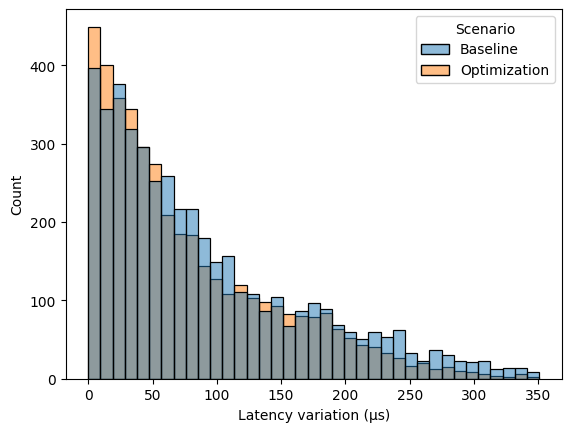

In [23]:
g = sns.histplot(data=latency_diff_p99, x='Latency_diff', hue='Scenario')

g.set(
    #title='Latency -- p99',
    xlabel='Latency variation (µs)',
    #ylabel='Type',
    xticklabels=[format_ns(tick, 'us') for tick in g.get_xticks()],
);

In [24]:
(jitter['No Service Mesh'].Optimization , jitter['No Service Mesh'].Baseline)

(80861.11433578489, 83247.87771170317)